In [1]:
import os
import sys
from shutil import copyfile
import json
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# add parent directory of project to system path, to access all the packages in project, sys.path.append appends are not permanent
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('train.py')))))))

from src.model.VAEGAN.Encoder import Encoder 
from src.model.VAEGAN.Generator import Generator
from src.model.VAEGAN.Discriminator import Discriminator
from src.model.VAEGAN.UnsupervisedDiscriminator import UnsupervisedDiscriminator
from src.model.VAEGAN.SupervisedDiscriminator import SupervisedDiscriminator
from src.model.VAEGAN.VAEGAN import VAEGAN
from src.model.VAEGAN.dark_energy.GANMonitor import GANMonitor

In [2]:
readlines = ""
with open('Params.json') as file:
    readlines = file.read() 

Params = json.loads(readlines) 
latent_dim = Params['latent_dim'] 
epochs = Params['epochs']
patience = Params['patience']
lr_gen = Params['lr_gen']
beta_1_gen = Params['beta_1_gen']
lr_disc = Params['lr_disc']
beta_1_disc= Params['beta_1_disc']
batch_size = Params['batch_size']
input_dim = Params['input_dim']
output_dim = Params['output_dim']
n_classes = Params['n_classes']
train_size = Params['train_size']
buffer_size = train_size 
outdir = Params['outdir'] 

if not os.path.isdir(outdir):
    os.makedirs(outdir)
if not os.path.isdir(os.path.join(outdir, 'fig')):
    os.mkdir(os.path.join(outdir, 'fig')) 
if not os.path.isdir(os.path.join(outdir, 'ckpt')):
    os.mkdir(os.path.join(outdir, 'ckpt'))
if not os.path.isdir(os.path.join(outdir, 'log')):
    os.mkdir(os.path.join(outdir, 'log'))

copyfile('Params.json',os.path.join(outdir, 'Params.json'))

'runs/run01/Params.json'

In [34]:
z = np.genfromtxt('../../../data/dark_energy_models/z.csv', dtype=np.float32)
x_real_580 = np.genfromtxt('../../../data/dark_energy_models/x_real_580_with_err.csv')

x_real = np.genfromtxt('../../../data/dark_energy_models/x_real.csv', dtype=np.float32)
y_real = np.genfromtxt('../../../data/dark_energy_models/y_real.csv', dtype=np.float32)

# normalize the y data, very important for GAN training
scaler_580 = StandardScaler()
scaler_580.fit(x_real_580[0].reshape(1,-1))
x_real_580 = scaler_580.transform(x_real_580)

scaler = StandardScaler()
scaler.fit(x_real[0].reshape(1,-1))
x_real = scaler.transform(x_real)

# split into test, validation, and training sets
x_train_580, x_test_580, x_train, x_test, y_train, y_test = train_test_split(x_real_580, x_real, y_real, test_size=0.2)
x_train_580, x_val_580, x_train, x_val, y_train, y_val = train_test_split(x_train_580, x_train, y_train, test_size=0.2)

In [4]:
train_dataset = ( 
    tf.data.Dataset
        .from_tensor_slices((x_train_580, x_train, y_train))
        .shuffle(buffer_size, reshuffle_each_iteration=True)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset
        .from_tensor_slices((x_val_580, x_val, y_val))
        .shuffle(buffer_size)
        .batch(batch_size)
)

test_dataset = (
    tf.data.Dataset
        .from_tensor_slices((x_test_580, x_test, y_test))
        .shuffle(buffer_size)
        .batch(batch_size)
)

2022-06-12 04:45:38.740290: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-06-12 04:45:38.740341: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: spk
2022-06-12 04:45:38.740351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: spk
2022-06-12 04:45:38.740498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-12 04:45:38.740535: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-06-12 04:45:38.740545: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- cannot find working devices in this configuration
2022-06-12 04:45:38.741228: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binar

In [5]:
encoder = Encoder(input_dim, latent_dim)
generator = Generator(latent_dim)
discriminator = Discriminator(output_dim, n_classes)
sup_discriminator = SupervisedDiscriminator(discriminator)
unsup_discriminator = UnsupervisedDiscriminator(discriminator)

In [6]:
vaegan = VAEGAN(latent_dim, encoder, generator, discriminator, sup_discriminator, unsup_discriminator, z, scaler)
vaegan.compile(
    tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=beta_1_gen),
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc), 
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc),
    tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=beta_1_gen),
    tf.keras.losses.BinaryCrossentropy(from_logits=False),
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
)

vaegan_checkpoint_path = os.path.join(outdir,"ckpt/vaegan.ckpt")
#g_checkpoint_path = os.path.join(outdir,"ckpt/generator.ckpt")
#d_checkpoint_path = os.path.join(outdir,"ckpt/discriminator.ckpt")

csvlogger_path = os.path.join(outdir,"log/log.txt")

callbacks = [
    #ModelCheckpoint(checkpoint_path, monitor='val_s_loss', save_best_only=True, save_weights_only=True, verbose=1),
    #EarlyStopping(monitor='val_s_loss', patience=patience, verbose=1),
    CSVLogger(csvlogger_path, separator=',', append=True),
    GANMonitor()
]

Epoch 1/10
240/240 [==============================] - ETA: 0s - e_loss: 0.4534 - s_loss: 1.1082 - u_loss: 0.7586 - g_loss: 0.5924 - s_acc: 0.3464 - u_acc: 0.5000

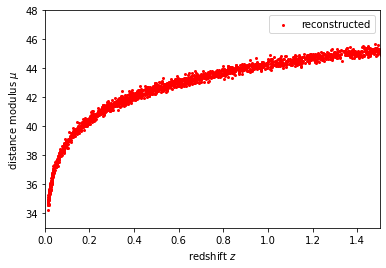

tf.Tensor([[0.31456915 0.34113976 0.3442911 ]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([2], shape=(1,), dtype=int64)
240/240 [==============================] - 28s 91ms/step - e_loss: 0.4534 - s_loss: 1.1082 - u_loss: 0.7586 - g_loss: 0.5924 - s_acc: 0.3464 - u_acc: 0.5000 - val_e_loss: 0.8020 - val_s_loss: 1.1225 - val_u_loss: 0.7229 - val_g_loss: 1.6079 - val_s_acc: 0.3021 - val_u_acc: 0.5000
Epoch 2/10
240/240 [==============================] - ETA: 0s - e_loss: 1.7770 - s_loss: 1.1016 - u_loss: 0.6668 - g_loss: 1.9790 - s_acc: 0.3479 - u_acc: 0.4904

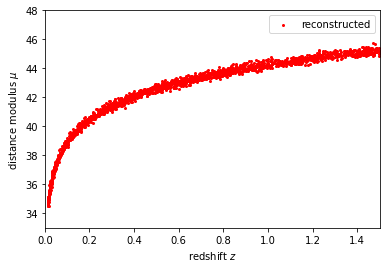

tf.Tensor([[0.31850243 0.33343413 0.34806347]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([2], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 83ms/step - e_loss: 1.7770 - s_loss: 1.1016 - u_loss: 0.6668 - g_loss: 1.9790 - s_acc: 0.3479 - u_acc: 0.4904 - val_e_loss: 2.5113 - val_s_loss: 1.1123 - val_u_loss: 0.6149 - val_g_loss: 13.9736 - val_s_acc: 0.3500 - val_u_acc: 0.4833
Epoch 3/10
240/240 [==============================] - ETA: 0s - e_loss: 3.0589 - s_loss: 1.1152 - u_loss: 0.5427 - g_loss: 3.2961 - s_acc: 0.3599 - u_acc: 0.4896

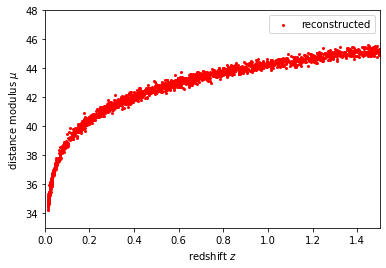

tf.Tensor([[0.3385029 0.3284928 0.3330043]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([0], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 83ms/step - e_loss: 3.0589 - s_loss: 1.1152 - u_loss: 0.5427 - g_loss: 3.2961 - s_acc: 0.3599 - u_acc: 0.4896 - val_e_loss: 2.7552 - val_s_loss: 1.1473 - val_u_loss: 0.4941 - val_g_loss: 2.3046 - val_s_acc: 0.3396 - val_u_acc: 0.5146
Epoch 4/10
240/240 [==============================] - ETA: 0s - e_loss: 2.3611 - s_loss: 1.1533 - u_loss: 0.4243 - g_loss: 2.2595 - s_acc: 0.3542 - u_acc: 0.6802

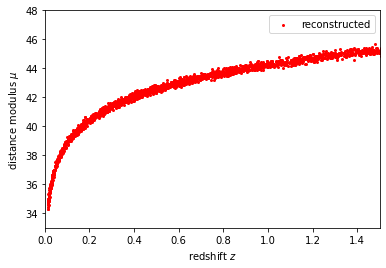

tf.Tensor([[0.28965533 0.32239527 0.38794944]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([2], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 83ms/step - e_loss: 2.3611 - s_loss: 1.1533 - u_loss: 0.4243 - g_loss: 2.2595 - s_acc: 0.3542 - u_acc: 0.6802 - val_e_loss: 2.1173 - val_s_loss: 1.1863 - val_u_loss: 0.3775 - val_g_loss: -11.1334 - val_s_acc: 0.3688 - val_u_acc: 0.8344
Epoch 5/10
240/240 [==============================] - ETA: 0s - e_loss: 2.2073 - s_loss: 1.1784 - u_loss: 0.3212 - g_loss: 1.8746 - s_acc: 0.3443 - u_acc: 0.9172

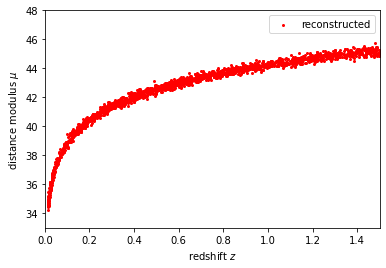

tf.Tensor([[0.26206872 0.30056542 0.4373659 ]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([2], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 83ms/step - e_loss: 2.2073 - s_loss: 1.1784 - u_loss: 0.3212 - g_loss: 1.8746 - s_acc: 0.3443 - u_acc: 0.9172 - val_e_loss: 2.2298 - val_s_loss: 1.2053 - val_u_loss: 0.2911 - val_g_loss: -15.0031 - val_s_acc: 0.3750 - val_u_acc: 0.9542
Epoch 6/10
240/240 [==============================] - ETA: 0s - e_loss: 2.4776 - s_loss: 1.1788 - u_loss: 0.2493 - g_loss: 2.1539 - s_acc: 0.3495 - u_acc: 0.9773

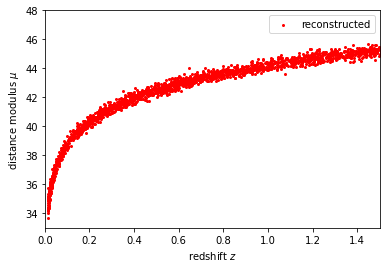

tf.Tensor([[0.3392048  0.32960904 0.33118623]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([0], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 83ms/step - e_loss: 2.4776 - s_loss: 1.1788 - u_loss: 0.2493 - g_loss: 2.1539 - s_acc: 0.3495 - u_acc: 0.9773 - val_e_loss: 2.6159 - val_s_loss: 1.2094 - val_u_loss: 0.2261 - val_g_loss: -18.4932 - val_s_acc: 0.3250 - val_u_acc: 0.9885
Epoch 7/10
240/240 [==============================] - ETA: 0s - e_loss: 3.0549 - s_loss: 1.1666 - u_loss: 0.1833 - g_loss: 2.5298 - s_acc: 0.3495 - u_acc: 0.9958

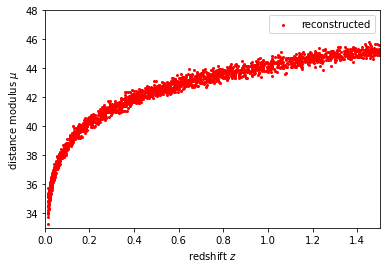

tf.Tensor([[0.2651693  0.26910457 0.46572614]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([2], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 83ms/step - e_loss: 3.0549 - s_loss: 1.1666 - u_loss: 0.1833 - g_loss: 2.5298 - s_acc: 0.3495 - u_acc: 0.9958 - val_e_loss: 3.3839 - val_s_loss: 1.1968 - val_u_loss: 0.1591 - val_g_loss: -28.1634 - val_s_acc: 0.3333 - val_u_acc: 0.9990
Epoch 8/10
240/240 [==============================] - ETA: 0s - e_loss: 4.1760 - s_loss: 1.1585 - u_loss: 0.1244 - g_loss: 3.2373 - s_acc: 0.3510 - u_acc: 0.9997

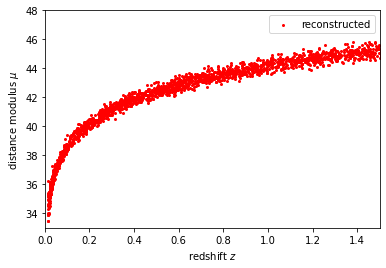

tf.Tensor([[0.31280464 0.32788938 0.359306  ]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([2], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 83ms/step - e_loss: 4.1760 - s_loss: 1.1585 - u_loss: 0.1244 - g_loss: 3.2373 - s_acc: 0.3510 - u_acc: 0.9997 - val_e_loss: 4.7333 - val_s_loss: 1.1777 - val_u_loss: 0.1125 - val_g_loss: -35.3944 - val_s_acc: 0.3417 - val_u_acc: 1.0000
Epoch 9/10
240/240 [==============================] - ETA: 0s - e_loss: 5.5328 - s_loss: 1.1451 - u_loss: 0.0819 - g_loss: 4.0679 - s_acc: 0.3604 - u_acc: 1.0000

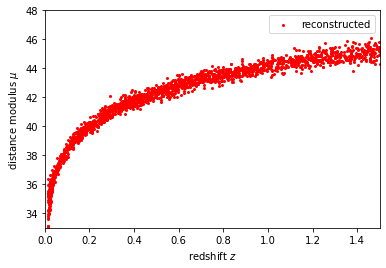

tf.Tensor([[0.2514917  0.37764683 0.3708615 ]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([1], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 83ms/step - e_loss: 5.5328 - s_loss: 1.1451 - u_loss: 0.0819 - g_loss: 4.0679 - s_acc: 0.3604 - u_acc: 1.0000 - val_e_loss: 5.6292 - val_s_loss: 1.1647 - val_u_loss: 0.0755 - val_g_loss: -43.7429 - val_s_acc: 0.3771 - val_u_acc: 1.0000
Epoch 10/10
240/240 [==============================] - ETA: 0s - e_loss: 6.5965 - s_loss: 1.1395 - u_loss: 0.0626 - g_loss: 4.7198 - s_acc: 0.3745 - u_acc: 1.0000

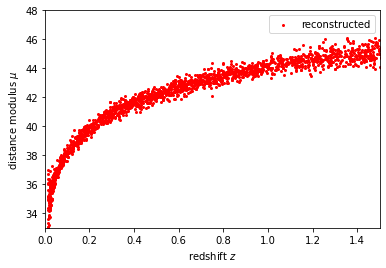

tf.Tensor([[0.35807058 0.3588322  0.2830972 ]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([1], shape=(1,), dtype=int64)
240/240 [==============================] - 20s 82ms/step - e_loss: 6.5965 - s_loss: 1.1395 - u_loss: 0.0626 - g_loss: 4.7198 - s_acc: 0.3745 - u_acc: 1.0000 - val_e_loss: 6.7791 - val_s_loss: 1.1708 - val_u_loss: 0.0598 - val_g_loss: -48.9577 - val_s_acc: 0.3812 - val_u_acc: 1.0000


In [7]:
history = vaegan.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data = val_dataset,
    callbacks = callbacks
)

In [8]:
#generator.save_weights(g_checkpoint_path)
#discriminator.save_weights(d_checkpoint_path)
vaegan.save_weights(vaegan_checkpoint_path)

In [9]:
# load the best model
vaegan.load_weights(vaegan_checkpoint_path)

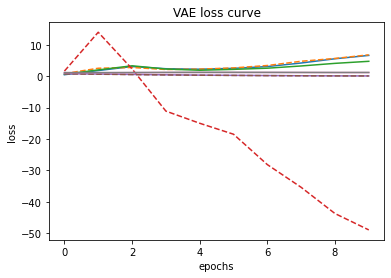

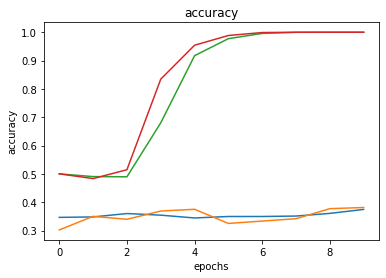

In [10]:
# number of epochs, early stopped or not
epochs = len(history.history['s_loss'])

plt.figure()
plt.plot(history.history['e_loss'], '-', label='e_loss')
plt.plot(history.history['val_e_loss'], '--', label='val_e_loss')
plt.plot(history.history['g_loss'], '-', label='g_loss')
plt.plot(history.history['val_g_loss'], '--', label='val_g_loss')
plt.plot(history.history['u_loss'], '-', label='u_loss')
plt.plot(history.history['val_u_loss'], '--', label='val_u_loss')
plt.plot(history.history['s_loss'], label='s_loss')
plt.plot(history.history['val_s_loss'], label='val_s_loss')
plt.title('VAE loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig(os.path.join(outdir,'fig/loss_curve.png'))
plt.draw()
plt.pause(0.001)
#plt.show()

plt.figure()
plt.plot(history.history['s_acc'], label='s_acc')
plt.plot(history.history['val_s_acc'], label='val_s_acc')
plt.plot(history.history['u_acc'], label='u_acc')
plt.plot(history.history['val_u_acc'], label='val_u_acc')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig(os.path.join(outdir,'fig/accuracy.png'))
plt.draw()
plt.pause(0.001)
#plt.show()

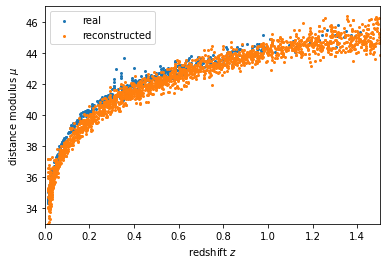

tf.Tensor([[0.35067567 0.3228088  0.3265156 ]], shape=(1, 3), dtype=float32)
Class :  tf.Tensor([0], shape=(1,), dtype=int64)


In [44]:
z_mean, z_logvar = encoder(x_test_580[0].reshape(-1,580)) 
z = vaegan.sampling((z_mean, z_logvar)) # re-parameterize
x_interpolate = generator(z)

z_obs = np.genfromtxt('../../../data/dark_energy_models/z_obs.csv', dtype=np.float32)

plt.scatter(z_obs, scaler_580.inverse_transform(x_test_580[0].reshape(-1,580)), s=4, label='real')
plt.scatter(vaegan.z, scaler.inverse_transform(x_interpolate.numpy()), s=4, label='reconstructed')
plt.xlim(0,1.5)
plt.ylim(33,47)
plt.xlabel(r'redshift $z$')
plt.ylabel(r'distance modulus $\mu$')
plt.legend()
plt.show()

pred = vaegan.s_discriminator(x_interpolate)
print(pred)
print('Class : ',tf.argmax(pred, axis=-1))